# Car Evaluator Predictor | Random Forest with 99.8% of Accuracy

## Description

In this notebook, the construction of a Random Forest model will be carried out, seeking to obtain maximum precision in the classification for the acceptability of a car based on the opinions of several surveyed users.

![Car Evaluator Predictor](cars.jpg)

### Targets:

* Perform an Exploratory Data Analysis.
* Describe which are the features of the best and the worst car in the market according to the users. 
* Perform an analysis of the characteristics that will adjust the model.
* Perform an oversampling to balance the data set.
* Create and train a Random Forest model, seeking to fine-tune its hyperparameters as much as possible using a Cross Validation search mesh.
* Obtain predictions from the model with the adjusted hyperparameters.
* Perform the metrics regard to the model created.
* Draw conclusions regarding the entire process.

## 1. Library importation

In [1]:
import random
import math
import time

# Data management
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# Oversampling Technique
from imblearn.over_sampling import SMOTE

from collections import Counter

# Data Splitting
from sklearn.model_selection import train_test_split as tts

# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV as GSCV

# Model metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import classification_report as cr

## 2. Load and Information of the data

In [2]:
df = pd.read_csv('car.csv')

### Data fields
* buying: Buying price of the car (v-high, high, med, low)
* maint: Price of the maintenance of car (v-high, high, med, low)
* doors: Number of doors (2, 3, 4, 5-more)
* persons: Capacity in terms of persons to carry (2, 4, more)
* lug_boot: The size of luggage boot (small, med, big)
* safety: Estimated safety of the car (low, med, high)
* evaluation: Car acceptability (unacc: unacceptible, acc: acceptible, good: good,   v-good: very good)

In [3]:
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'evaluation']
df.columns = columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   buying      1727 non-null   object
 1   maint       1727 non-null   object
 2   doors       1727 non-null   object
 3   persons     1727 non-null   object
 4   lug_boot    1727 non-null   object
 5   safety      1727 non-null   object
 6   evaluation  1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [5]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,evaluation
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [6]:
df.describe()

,buying,maint,doors,persons,lug_boot,safety,evaluation
count,1727,1727,1727,1727,1727,1727,1727
unique,4,4,4,3,3,3,4
top,high,high,3,4,med,med,unacc
freq,432,432,432,576,576,576,1209


## 3. Exploratory Data Analysis & Data transforming

### 3.1 Missing data

Let's see if there some lost data.

[Text(0.5, 1.0, 'Existent data (purple) and missing data (yellow) ratio')]

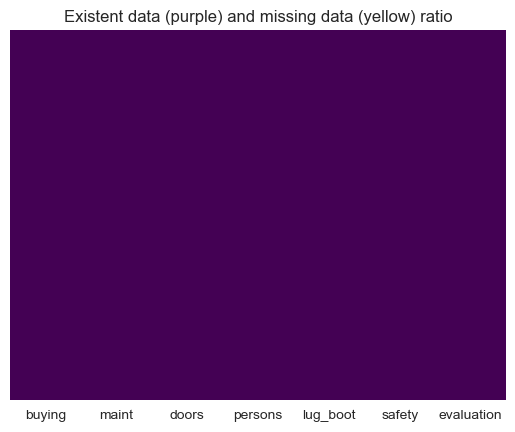

In [7]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis').set(title = 'Existent data (purple) and missing data (yellow) ratio')

In [8]:
df.isnull().sum()

buying        0
maint         0
doors         0
persons       0
lug_boot      0
safety        0
evaluation    0
dtype: int64

### 3.2 Column encoding

To have a better management of the data, we will encode all the strings columns to a quantitative value columns for every feature.

In [15]:
mapping = {
    
    'm_buying_and_maint' : {
        # For 'buying' & 'maint' columns.
        'low': 1,
        'med': 2,
        'high': 3,
        'vhigh': 4,
    },
    
    'm_doors' : {
        # For 'doors' columns.
        '2': 1,
        '3': 2,
        '4': 3,
        '5more': 4,
    },
    
    'm_persons' : {
        # For 'persons' columns.
        '2': 1,
        '4': 2,
        'more': 3,
    },
    
    'm_lug_boot' : {
        # For 'lug_boot' column.
        'small': 1,
        'med': 2,
        'big': 3,
    },
    
    'm_safety' : {
        # For 'safety' column.
        'low': 1,
        'med': 2,
        'high': 3,
    },
    
    'm_evaluation' : {
        # For 'evaluation' column.
        'unacc': 1,
        'acc': 2,
        'good': 3,
        'vgood': 4
    }
}

df_encoded = df

df_encoded['buying'] = df['buying'].replace(mapping['m_buying_and_maint'])
df_encoded['maint'] = df['maint'].replace(mapping['m_buying_and_maint'])
df_encoded['doors'] = df['doors'].replace(mapping['m_doors'])
df_encoded['persons'] = df['persons'].replace(mapping['m_persons'])
df_encoded['lug_boot'] = df['lug_boot'].replace(mapping['m_lug_boot'])
df_encoded['safety'] = df['safety'].replace(mapping['m_safety'])
df_encoded['evaluation'] = df['evaluation'].replace(mapping['m_evaluation'])

df_encoded.head()

,buying,maint,doors,persons,lug_boot,safety,evaluation
0,4,4,1,1,1,2,1
1,4,4,1,1,1,3,1
2,4,4,1,1,2,1,1
3,4,4,1,1,2,2,1
4,4,4,1,1,2,3,1


### 3.3 Evaluation counting

Now let's see the balance of the data labels.

[Text(0.5, 1.0, 'Number of cars per evaluation')]

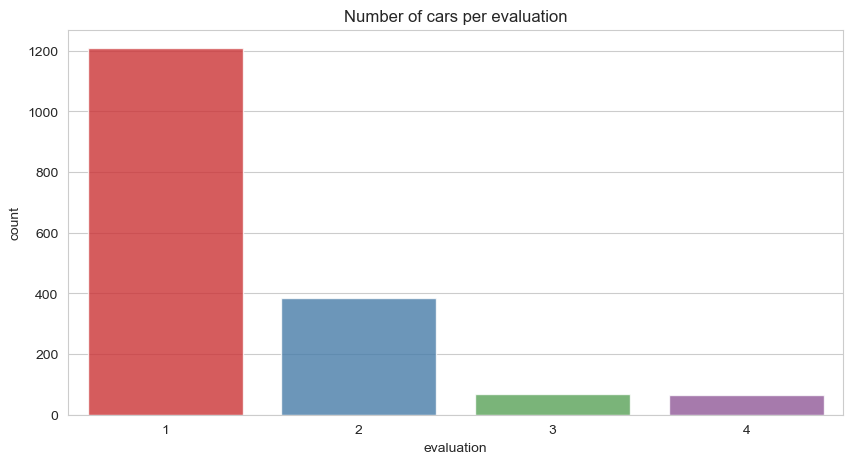

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_encoded, x='evaluation', palette='Set1', alpha=0.8).set(title = 'Number of cars per evaluation')

In [30]:
print(Counter(df_encoded['evaluation']))

Counter({1: 1209, 2: 384, 3: 69, 4: 65})


It seems that the data labels are imbalance with a bias in the worst rated cars (value 1), this will must be corrected in the future to not transmit that bias to the model.

### 3.4 Features of the best and the worst car in the market

Now, we will focus on find out which are the set of features that better describe the best and the worst car in the market.

In [41]:
# The best and the worst evaluated cars.
highest = df_encoded[df_encoded['evaluation'] == 4]
lowest = df_encoded[df_encoded['evaluation'] == 1]

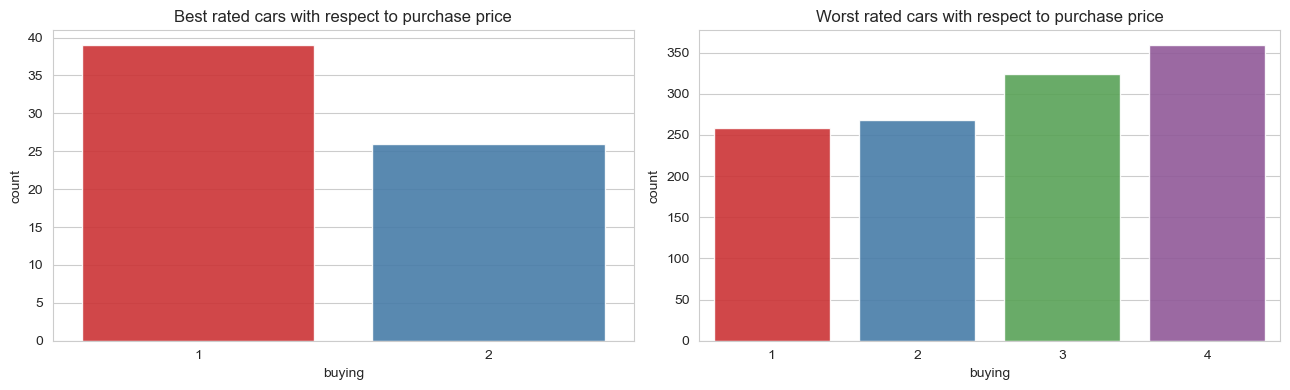

In [48]:
# What are the worst and best cars according to purchase price?
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,4))

axes[0].set_title('Best rated cars with respect to purchase price')
sns.countplot(ax=axes[0], data=highest, x='buying', palette='Set1', alpha=0.9)

axes[1].set_title('Worst rated cars with respect to purchase price')
sns.countplot(ax=axes[1], data=lowest, x='buying', palette='Set1', alpha=0.9)

plt.tight_layout()

According to these plots, the best car has to be cheap, and on the other hand, the worst car is the expensive one.

Note: Remember the coding of the buying price.

* 1: low price
* 2: medium price
* 3: high price
* 4: very high price

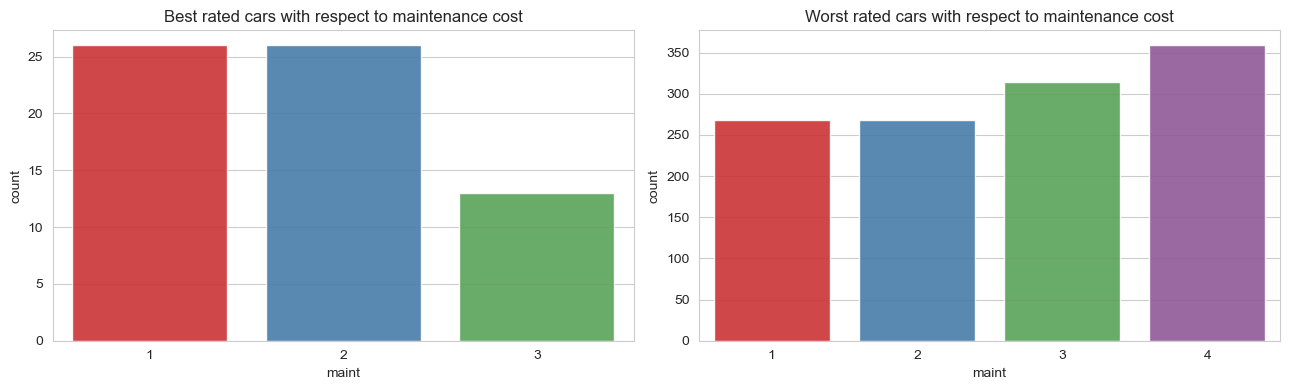

In [49]:
# What are the worst and best cars according to maintenance cost?
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,4))

axes[0].set_title('Best rated cars with respect to maintenance cost')
sns.countplot(ax=axes[0], data=highest, x='maint', palette='Set1', alpha=0.9)

axes[1].set_title('Worst rated cars with respect to maintenance cost')
sns.countplot(ax=axes[1], data=lowest, x='maint', palette='Set1', alpha=0.9)

plt.tight_layout()

Following the previous tendance, it's similar for the maintenance cost, the best car must be the cheapest to maintain, and the worst car will be the most expensive to maintain.

Note: Remember the coding of the maintenance cost.

* 1: low cost
* 2: medium cost
* 3: high cost
* 4: very high cost

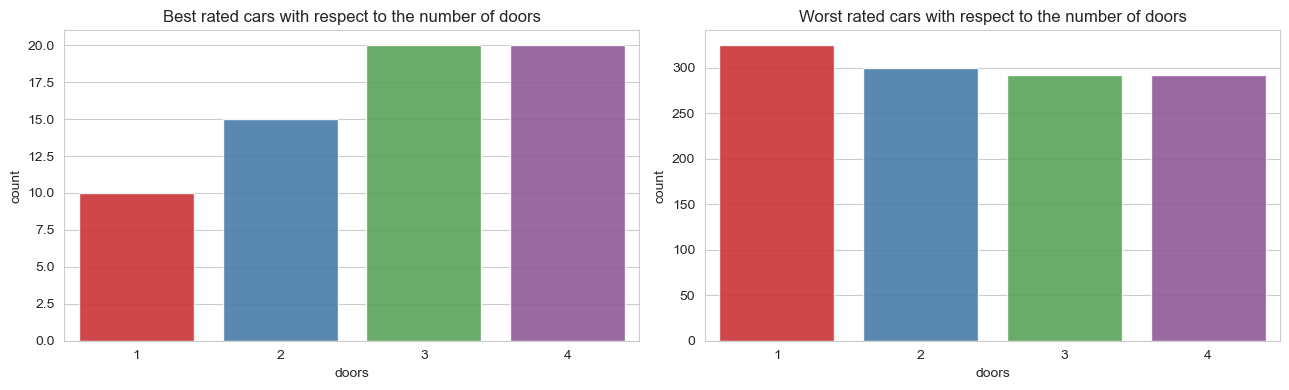

In [42]:
# What are the worst and best cars based on the number of doors?
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,4))

axes[0].set_title('Best rated cars with respect to the number of doors')
sns.countplot(ax=axes[0], data=highest, x='doors', palette='Set1', alpha=0.9)

axes[1].set_title('Worst rated cars with respect to the number of doors')
sns.countplot(ax=axes[1], data=lowest, x='doors', palette='Set1', alpha=0.9)

plt.tight_layout()

Like it was expected, the best rated cars are those which have more doors than the other ones which are worst rated and have less doors.

Note: Remember the coding of the number of doors.

* 1: 2 doors
* 2: 3 doors
* 3: 4 doors
* 4: 5 or more doors

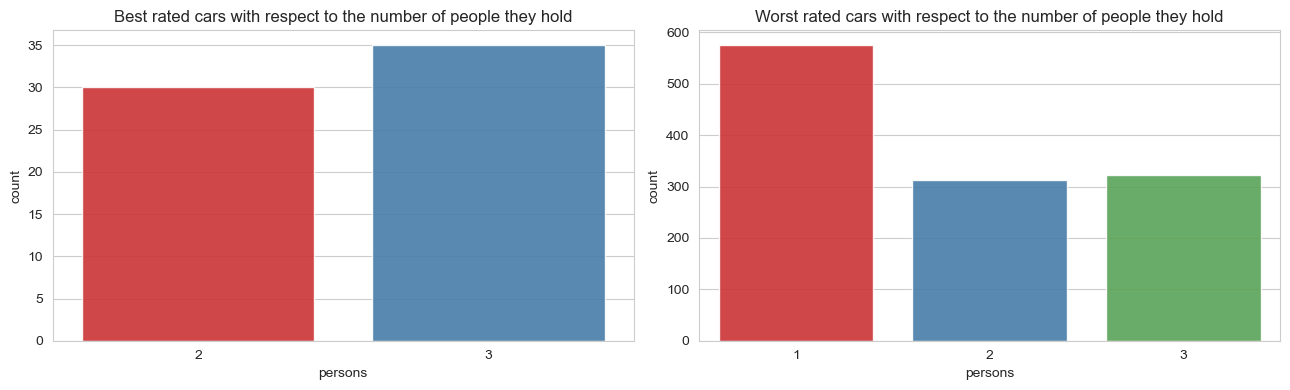

In [44]:
# What are the worst and best cars based on the number of people they hold?
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,4))

axes[0].set_title('Best rated cars with respect to the number of people they hold')
sns.countplot(ax=axes[0], data=highest, x='persons', palette='Set1', alpha=0.9)

axes[1].set_title('Worst rated cars with respect to the number of people they hold')
sns.countplot(ax=axes[1], data=lowest, x='persons', palette='Set1', alpha=0.9)

plt.tight_layout()

Likewise, this trend is similar to the previous one, since cars that have capacity for several people are better valued than those that do not have that type of capacity.

Note: Remember the coding of the number of persons.

* 1: 2 persons
* 2: 4 persons
* 3: more than 4 persons

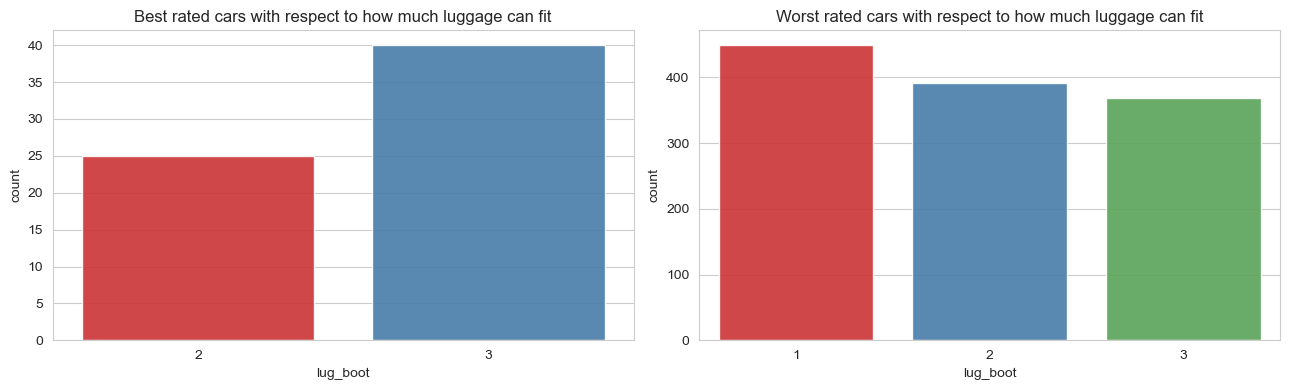

In [45]:
# What are the worst and best cars based on how much luggage can fit?
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,4))

axes[0].set_title('Best rated cars with respect to how much luggage can fit')
sns.countplot(ax=axes[0], data=highest, x='lug_boot', palette='Set1', alpha=0.9)

axes[1].set_title('Worst rated cars with respect to how much luggage can fit')
sns.countplot(ax=axes[1], data=lowest, x='lug_boot', palette='Set1', alpha=0.9)

plt.tight_layout()

Finally, the luggage case is the same like the doors and the people capacity, the best rated cars are those with more space for the luggage, end the worst rated cars are those that doesn't have so much space for the luggage.

Note: Remember the coding of the luggage space.

* 1: small luggage
* 2: medium luggage
* 3: big luggage

In summary, the best-rated vehicle is characterized by offering ample space for both passengers and luggage, as well as a greater number of doors. All this, always considering its accessibility at an affordable price both in its acquisition and in its maintenance.

On the other hand, the less favorable aspect lies in its limited space for passengers and luggage, as well as the availability of a reduced number of doors, resulting in a high cost both in its purchase and in its maintenance.

It is important to note that this superficial analysis does not consider the vehicle's model year or its segment, since comparing a Mini Cooper with other standard vehicles is different from comparing a two-door Ferrari with high-end cars.

### 3.5 Features correlation matrix

To figure out which features are relevant for the model fit, it will perform the next heat map to appreciate the correlation between features.

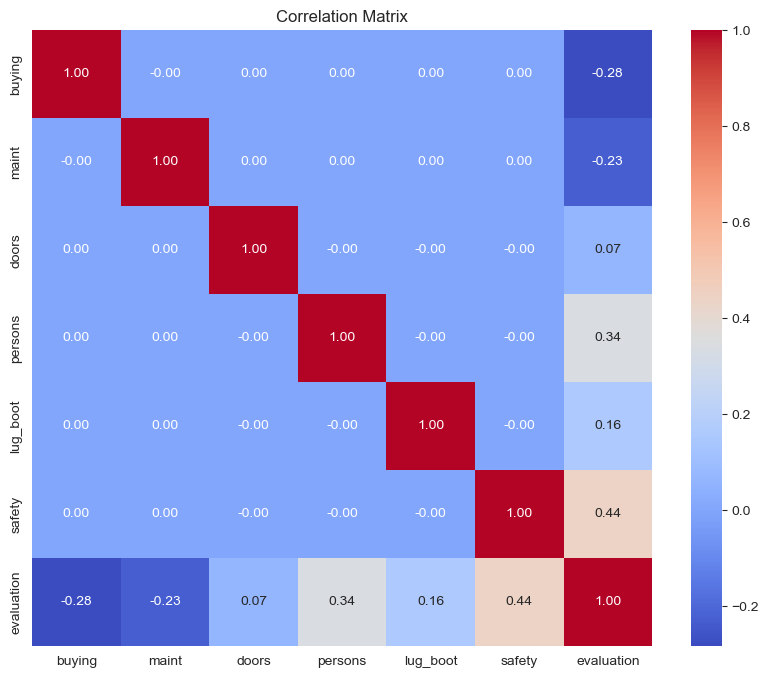

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_enconded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Seeing the correlation matrix, we can determine that all the features are relevant for the evaluation, since for this case we will consider that a feature is irrelevant if its correlation coefficient has a value less than 0.05.

## 4. Model construction

### 4.1 Data oversampling

To correct the imbalance in the data set we can perform an unbalanced oversampling technique, in order to counteract the bias in the data and to expand the number of instance that will feed our model.

For this case we will use de Synthetic Minority Over-sampling Technique (SMOTE) to up-sample the minority classes while avoiding overfitting.

In [17]:
x = df_encoded.drop(['evaluation'], axis=1)
y = df_encoded['evaluation']

s = SMOTE(k_neighbors=2)
x, y = s.fit_resample(x, y)

print(f'Total of labels: {len(y)}')
print(Counter(y))

Total of labels: 4836
Counter({1: 1209, 2: 1209, 4: 1209, 3: 1209})


### 4.2 Data spliting

In [14]:
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.33, random_state=101)

print("Shape of x:", x.shape)
print("Shape of y:", y.shape)
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x: (4836, 6)
Shape of y: (4836,)
Shape of x_train: (3240, 6)
Shape of x_test: (1596, 6)
Shape of y_train: (3240,)
Shape of y_test: (1596,)


### 4.3 Creating the model

For this case we will use a Random Forest model, to carry out the classification of interest.

In [15]:
# Initialize and train the Random Forest model
rf_classifier = RandomForestClassifier(random_state=42)

# Obtener los hiperparámetros del modelo
params = rf_classifier.get_params()

# Mostrar los hiperparámetros y sus valores actuales
for param, value in params.items():
    print(f'{param}: {value}')

bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


### 4.4 Grid Search Cross Validation

Now, we will adjust our Random Forest model through cross-validation and the search for optimality of the best values and combinations of parameters that are introduced into the mesh grid.

In [16]:
# Gridserch criteria
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_features': ['sqrt', 'log2'],
              'n_estimators': [100, 1000, 10000], 
              }

start = time.time()

# Gridsearch
grid = GSCV(rf_classifier, param_grid, refit=True, verbose=3)

grid.fit(x_train, y_train)

end = time.time()
elapsed_time = end - start

print('\n')
print(f"Grid search elapsed time: {elapsed_time} seconds")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.992 total time=   0.1s
[CV 2/5] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.989 total time=   0.1s
[CV 3/5] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.998 total time=   0.1s
[CV 4/5] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.988 total time=   0.1s
[CV 5/5] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.985 total time=   0.1s
[CV 1/5] END criterion=gini, max_features=sqrt, n_estimators=1000;, score=0.992 total time=   4.4s
[CV 2/5] END criterion=gini, max_features=sqrt, n_estimators=1000;, score=0.989 total time=   4.9s
[CV 3/5] END criterion=gini, max_features=sqrt, n_estimators=1000;, score=0.997 total time=   4.8s
[CV 4/5] END criterion=gini, max_features=sqrt, n_estimators=1000;, score=0.988 total time=   4.8s
[CV 5/5] END criterion=gini, max_features=sqrt, n_est

[CV 2/5] END criterion=log_loss, max_features=log2, n_estimators=1000;, score=0.989 total time=   4.9s
[CV 3/5] END criterion=log_loss, max_features=log2, n_estimators=1000;, score=0.995 total time=   5.0s
[CV 4/5] END criterion=log_loss, max_features=log2, n_estimators=1000;, score=0.988 total time=   5.0s
[CV 5/5] END criterion=log_loss, max_features=log2, n_estimators=1000;, score=0.986 total time=   5.0s
[CV 1/5] END criterion=log_loss, max_features=log2, n_estimators=10000;, score=0.992 total time=  51.3s
[CV 2/5] END criterion=log_loss, max_features=log2, n_estimators=10000;, score=0.989 total time=  50.9s
[CV 3/5] END criterion=log_loss, max_features=log2, n_estimators=10000;, score=0.997 total time=  52.1s
[CV 4/5] END criterion=log_loss, max_features=log2, n_estimators=10000;, score=0.988 total time=  53.3s
[CV 5/5] END criterion=log_loss, max_features=log2, n_estimators=10000;, score=0.986 total time=  51.2s


Grid search elapsed time: 1696.8005740642548 seconds


Finally, we get the best fit for our Random forest model.

In [17]:
print('Random Forest Model')
print('Best param in "criterion": ', grid.best_params_['criterion'])
print('Best param in "max_features": ', grid.best_params_['max_features'])
print('Best param in "n_estimators": ', grid.best_params_['n_estimators'], '\n')

Random Forest Model
Best param in "criterion":  entropy
Best param in "max_features":  sqrt
Best param in "n_estimators":  100 



### 4.5 Predictions

Let's create some predictions.

In [18]:
predictions = grid.predict(x_test)

print(Counter(predictions))

Counter({1: 406, 2: 406, 4: 398, 3: 386})


[Text(0.5, 1.0, 'Number of cars per evaluation')]

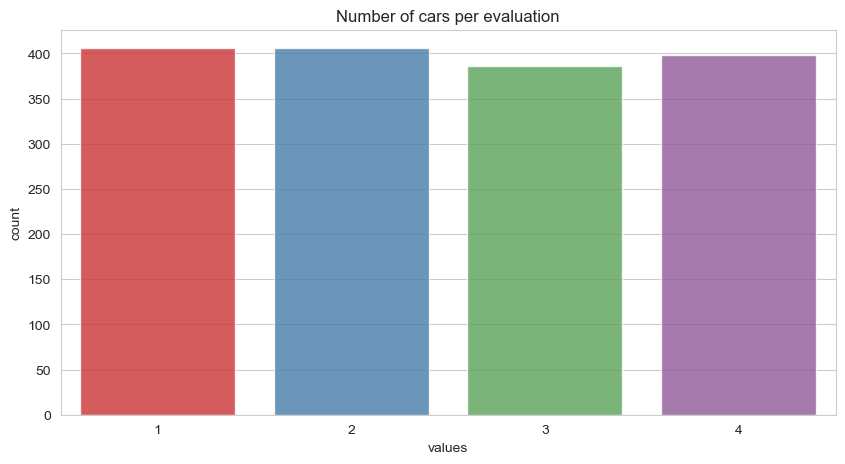

In [19]:
# Convertir el array de NumPy a un DataFrame de pandas
df_pred = pd.DataFrame(predictions, columns=['values'])

# Crear el count plot usando seaborn
plt.figure(figsize=(10,5))
sns.countplot(data=df_pred, x='values', palette='Set1', alpha=0.8).set(title = 'Number of cars per evaluation')

The trend and volume of predictions look good, now let's see how the model performed.

## 5. Model Metrics

Now, we will obtain the mtrics of our model development, first of all let's make a quick report of the metrics, and then we will see the confusion matrix regard to our classification.

### 5.1 Metrics report

In [20]:
print(cr(y_test, predictions))

[[406   2   1   0]
 [  0 404   0   0]
 [  0   0 385   0]
 [  0   0   0 398]] 

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       409
           2       1.00      1.00      1.00       404
           3       1.00      1.00      1.00       385
           4       1.00      1.00      1.00       398

    accuracy                           1.00      1596
   macro avg       1.00      1.00      1.00      1596
weighted avg       1.00      1.00      1.00      1596



### 5.2 Confusion matrix

Model Accuracy: 99.81%


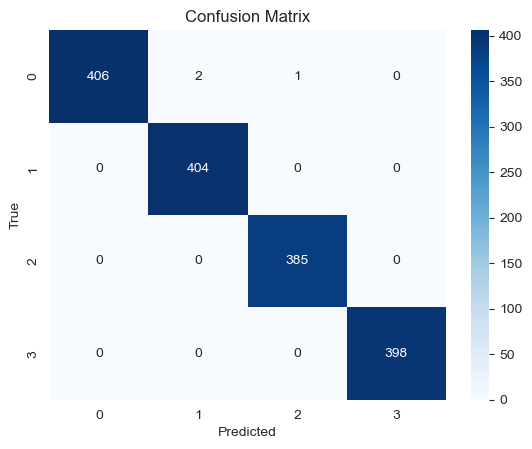

In [20]:
print(f'Model Accuracy: {round(accuracy_score(y_test , predictions)*100, 2)}%')

# Visualize the confusion matrix with seaborn
sns.heatmap(cm(y_test, predictions), annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 7. Conclusion

In the exploratory analysis, we identified the characteristics that impact the evaluation of a car. However, a more detailed analysis could uncover the dominant attributes in a car with a strong cost-benefit ratio. This could be achieved with a dataset providing more information related to purchase amounts, user satisfaction levels, market niche, and automobile ranges.

The model's success can be attributed to optimal fitting techniques such as oversampling and cross-validation using mesh grids. These approaches yielded excellent accuracy without overfitting, thanks to techniques like SMOTE, enabling the creation of new instances while preserving each characteristic's distribution.

Based on the entire process outlined, the model appears reliable and ready for application to new datasets akin to the discussed one.